This module extract reporter country trade data for a specified crop, normalize and visualize data, then fit ARIMA models to each country's data with gridsearch. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
# Read in processed data
items_by_country = pd.read_csv('../data/processed/items_by_country.csv',index_col=0)
print(items_by_country.shape)

(223049, 38)


In [3]:
items_by_country.head()

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
0,Afghanistan,Almonds shelled,Export Quantity,tonnes,5313,0.0,0.0,0.0,0.0,0.0,...,4763.0,1308.0,2261.0,0.0,0.0,2714.0,2086.0,1778.0,2756.0,7
1,Afghanistan,Almonds shelled,Export Value,1000 US$,5313,0.0,0.0,0.0,0.0,0.0,...,35476.0,15894.0,20270.0,0.0,0.0,16454.0,12793.0,10934.0,19677.0,7
2,Afghanistan,Almonds shelled,Import Quantity,tonnes,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,168.0,181.0,846.0,103.0,4
3,Afghanistan,Almonds shelled,Import Value,1000 US$,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1117.0,1377.0,4988.0,759.0,4
4,Afghanistan,"Almonds, with shell",Export Quantity,tonnes,3315,0.0,0.0,0.0,0.0,0.0,...,11066.0,779.0,1016.0,0.0,0.0,1856.0,1660.0,1545.0,875.0,7


In [4]:
# Put name for years into a column
years = items_by_country.columns[5:-1].tolist()

### Use wheat as an example

#### Step 1: extract data

In [59]:
# Get data for export value of wheat
# Assign variables
item = 'Wheat'
element = 'Export Value'

In [128]:
# %load functions/item_element_country.py

def item_element_country(df,item,element):
    '''function to take input of an item name, element name (e.g. Export/import value) and 
    output a formated file (aggregated by Reporter Countries) for downstream analysis'''
    
    data = df.loc[(df['Item']==item)&(df['Element']==element),:]
    data_50 = data.loc[data['NoneZero']>=16,:]
    print('{} country names selected for those with >50% non-zero data'.format(data_50.shape[0]) )
    
    # Reshape data from wide to long by years 
    data_long = data_50.melt(['Reporter Countries'],years,'year','value')
    
    # Convert data to time series
    data_long['year'] = data_long['year'].map(lambda x: x.lstrip('Y')) # strip Y from year names for easy converting to ts
    data_long.year = pd.to_datetime(data_long.year)
    
    # Reshape data from long to wide, turn countries into columns
    data_wide = data_long.pivot(index='year',columns='Reporter Countries',values='value')

    return data_wide


In [129]:
# Extract data
df_original = item_element_country(items_by_country, item, element) 

75 country names selected for those with >50% non-zero data


#### Step 2: normalize data

In [39]:
def df_normalize(df_original):
    '''function to transform and normalize crop trade data
    '''
    # calculate 3-year rolling mean to smooth data and add 1 to prep for log transformation
    # Assume that adding 1 tonne per year will not significantly change the time series patterns for any country
    rolled = df_original.rolling(3).sum().add(1)
    # Log-transformation to scale down countries with large numbers
    # Then divide each data point by the third row's value (removed first two rows which are NaNs)
    # So that all countries have the same start point 0 
    df_normalized = np.log(rolled[2:].div(rolled[2:].iloc[0]))
    
    return df_normalized

In [130]:
df_normalized = df_normalize(df_original)

#### Step 3: visualize original and normalized data

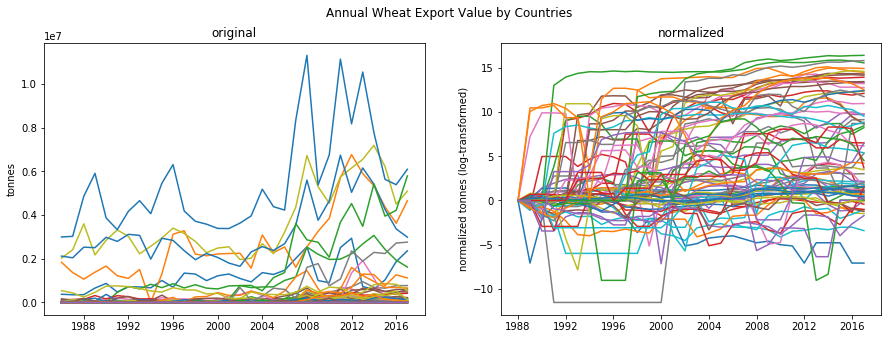

In [131]:
# Visually compare original data and normalized data
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(15,5))
ax1.plot(df_original)
ax2.plot(df_normalized)

ax1.set_title('original')
ax1.set_ylabel('tonnes')
ax2.set_title('normalized')
ax2.set_ylabel('normalized tonnes (log-transformed)')
fig.suptitle('Annual {} {} by Countries'.format(item,element))
plt.show()

import warnings
warnings.filterwarnings("ignore")

#### Step 4: check stationarity and remove non-stationary countries

In [85]:
# %load functions/stationarity.py
def stationarity(df):
    '''function to run Dickey-Fuller test on time series for each country,
    return list of countries that passed the test'''
    non_stationary_countries = []
    
    for country in df.columns:
        stationarity = adfuller(df[country].dropna())
        
        if stationarity[1] <= 0.05:
            non_stationary_countries.append(country)
        stationary_countries = [i for i in df.columns.tolist() if i not in non_stationary_countries]
    print('There were {} non-stationary countries being removed and\n result in {} stationary countries'.format(len(non_stationary_countries),
                                                                                                               len(stationary_countries)))
    return stationary_countries


In [132]:
# Check stationarity 
stationary_countries = stationarity(df_normalized)

# Remove non-stationary countries from data frame
df_processed = df_normalized[stationary_countries]

There were 16 non-stationary countries being removed and
 result in 59 stationary countries


In [133]:
print(df_processed.shape)

(30, 59)


#### Step 5 Training an ARIMA model for each country and use gridsearch to find best parameters

In [26]:
# %load functions/countries_arima.py
# ref: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

# Step 1: Evaluate an ARIMA model use MSE 
def eval_arima(data, order):
    '''function to split a time series into train and test set, build an ARIMA model
      use rolling one-at-a-time predictions, and reture mean squared error of the model'''
    
    # split dataset into training and testing
    train_size = int(len(data)*0.66)
    train, test = data[0: train_size], data[train_size:]
    
    # Make one prediction/forecast at a time, put the prediction into predictions list, 
    # then add one data from test set to train set for the next model
    rolling_train = [train_index for train_index in train]
    predictions = []
    for test_index in range(len(test)):
        model = ARIMA(rolling_train, order=order)
        model_fit = model.fit()
        one_prediction = model_fit.forecast()[0]
        predictions.append(one_prediction)
        rolling_train.append(test[test_index])
    mse = mean_squared_error(test, predictions)
    return mse

# Step 2: Grid search for order(p,d,q) of ARIMA model
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = [0, 1]
q_values = [0, 1, 2]
import warnings
warnings.filterwarnings("ignore")

def gridsearch_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = eval_arima(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    #print('ARIMA%s MSE=%.2E' %(order, mse)) # print out results for each configuration
                except:
                    continue
    print(data.name, best_cfg, 'MSE=%.2E' %best_score)
    return data.name, best_cfg, best_score
    

# Step 3: Loop through all countries to make predictions 
def countries_arima(data):

    results = []
    for country in data.columns:
        country_result = gridsearch_arima(data[country], p_values, d_values, q_values)
        results.append(country_result)
    results = pd.DataFrame(results, columns=['country','best_arima','mse'])
    return results


In [28]:
# Gridsearch to find best ARIMA models
df_arima = countries_arima(df_processed)

Afghanistan (0, 0, 0) MSE=0.00E+00
Albania (0, 1, 2) MSE=2.54E+00
Algeria (5, 1, 0) MSE=1.16E+00
Argentina (5, 0, 0) MSE=5.88E-02
Armenia (0, 1, 1) MSE=8.14E-01
Aruba (4, 0, 1) MSE=4.35E+00
Australia (2, 1, 2) MSE=1.77E-02
Austria (1, 1, 0) MSE=9.95E-03
Azerbaijan (0, 1, 0) MSE=4.12E+00
Bahrain (1, 0, 0) MSE=5.35E+00
Belarus (5, 1, 0) MSE=5.76E-01
Belgium (0, 1, 0) MSE=3.46E-01
Belgium-Luxembourg (0, 1, 0) MSE=2.88E-01
Benin (4, 0, 1) MSE=8.31E+00
Bolivia (Plurinational State of) (0, 1, 1) MSE=4.37E-02
Bosnia and Herzegovina (0, 1, 0) MSE=1.14E+00
Botswana (2, 0, 2) MSE=2.03E+00
Brazil (1, 0, 0) MSE=3.53E-01
Bulgaria (0, 1, 2) MSE=5.34E-02
Burkina Faso (1, 0, 2) MSE=3.40E-01
Burundi (0, 0, 2) MSE=2.40E+00
Cabo Verde (1, 0, 0) MSE=7.84E-01
Cambodia (0, 0, 0) MSE=4.10E-01
Canada (0, 1, 2) MSE=1.06E-02
Chile (0, 1, 0) MSE=1.47E-01
China, Hong Kong SAR (4, 1, 1) MSE=6.18E-01
China, Macao SAR (0, 0, 0) MSE=0.00E+00
China, Taiwan Province of (5, 0, 0) MSE=3.19E-01
China, mainland (1, 0, 0) M

In [91]:
results= df_arima.copy()

In [93]:
results = results.set_index('country')
results.to_csv('../data/processed/arima_{}_{}_.csv'.format(item,element))
results = results.sort_values(by='mse')

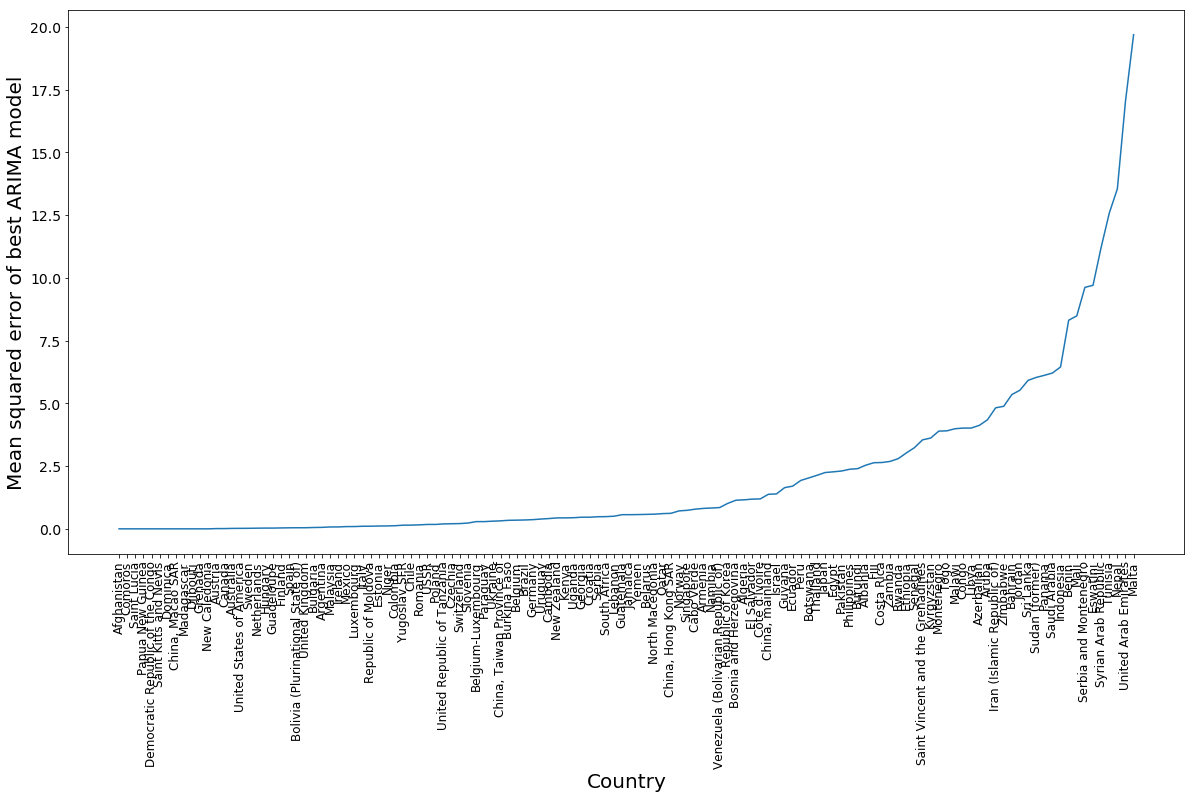

In [102]:
plt.figure(figsize=(20,10))
plt.plot(results['mse'])
plt.xlabel('Country',fontsize=20)
plt.ylabel('Mean squared error of best ARIMA model',fontsize=20)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.show()

In [124]:
# Select countries with at least 50% non-zero data
results_50pct = results.loc[[i for i in df_50_list if i in results.index]]

results_50pct = results_50pct.sort_values(by='mse')

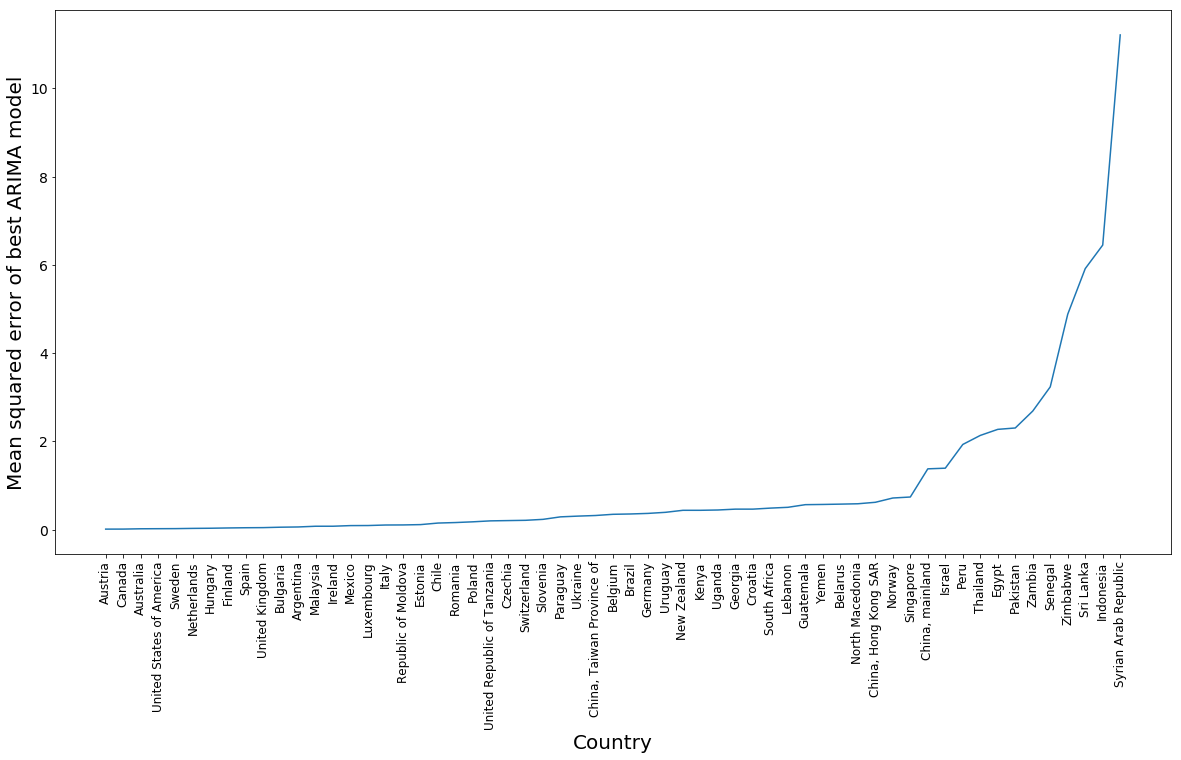

In [125]:
plt.figure(figsize=(20,10))
plt.plot(results_50pct['mse'])
plt.xlabel('Country',fontsize=20)
plt.ylabel('Mean squared error of best ARIMA model',fontsize=20)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
def function(data, crop, element, plots=True):
    
    
    if plots==True:
        plt.figure(figsize=(20,10))
        plt.plot(np.log(results['mse']))
        plt.xlabel('Country',fontsize=20)
        plt.ylabel('Mean squared error of best ARIMA model (log)',fontsize=20)
        plt.xticks(fontsize=12, rotation=90)
        plt.yticks(fontsize=14)
          plt.show()